# Import Libraries


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from mpl_toolkits.mplot3d import Axes3D

import sys
sys.path.append("../") 

import LISA as l
import Glitch as gl

# Create an instance of LISA's orbit and a Wavelet Object

In [42]:
# set up the LISA orbit
orb = l.Orbit(l.YEAR)
t = np.arange(0.0, orb.Tobs, orb.dt) # set up the time of this orbit
h = np.zeros(len(t))

print "Nyquist Freq........ {} mHz".format(orb.f_ny*1000.)

# set up parameters of wavelet
A    = 1.
f0   = 10.0e-3
tau  = 3600./60
t0   = 0.5*l.YEAR
phi0 = 0.

print "Q................... {}"  .format(np.pi*f0*tau)
print "tau................. {} s".format(tau)
print "dt.................. {} s".format(orb.dt)

wave = gl.Wavelet(A, f0, tau, t0, phi0, orb)
wave.calc_Psi()
wave.make_padded_Psi(t) # drop in the wavelet time series into the data stream
h = h + wave.Psi_padded

Nyquist Freq........ 33.3333333333 mHz
Q................... 1.88495559215
tau................. 60.0 s
dt.................. 15.0 s


## Plot the Wavelet Object in the SSB, time domain

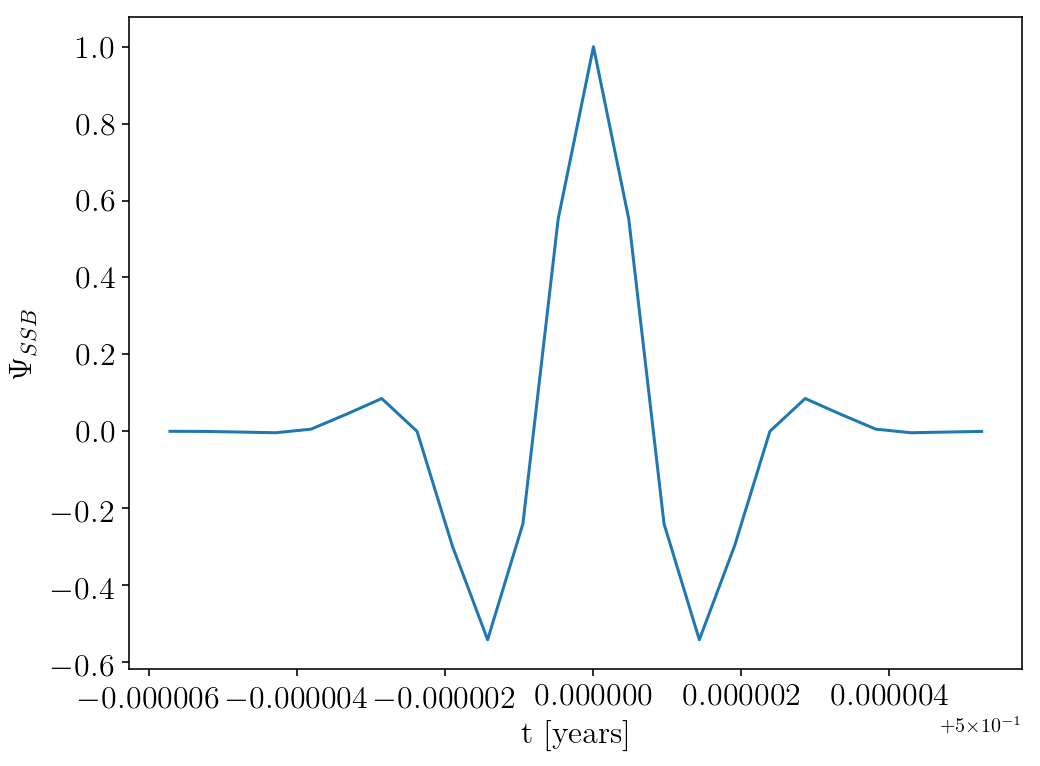

In [43]:
fig, ax = plt.subplots(1, figsize=(8,6))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
ax.set_xlabel(r't [years]', fontsize=16)
ax.set_ylabel(r'$\Psi_{\text{SSB}}$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)

ax.plot(wave.t/l.YEAR, wave.Psi)

plt.show()

# Generate TDI for instrument glitch injection

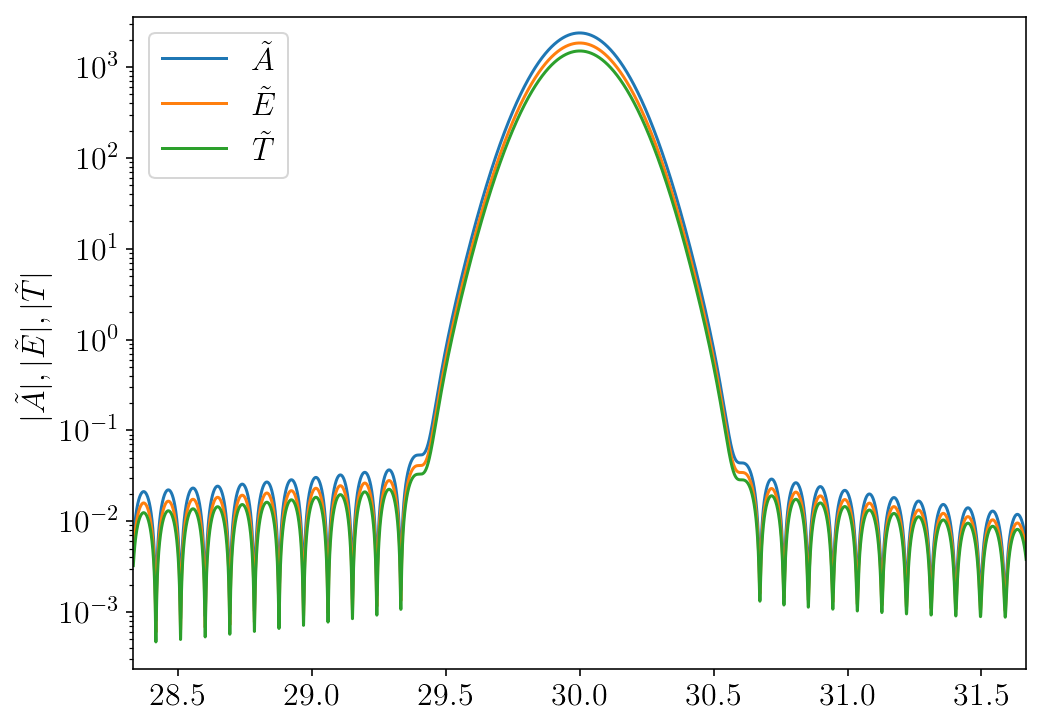

In [38]:
tdi = gl.create_instrument_glitch_TDI('Optical Path', 1, wave, orb, 2)
# tdi = gl.create_instrument_glitch_TDI('Laser Phase', 1, wave, orb, None)
# tdi = gl.create_instrument_glitch_TDI('Acceleration', 1, wave, orb, 3)

fig, ax = plt.subplots(1, figsize=(8,6))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

ax.set_ylabel(r'$|\tilde{A}|,|\tilde{E}|,|\tilde{T}|$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)

mult = 1000.
plt.xlim(wave.f_min*mult, wave.f_max*mult)

mask = (tdi.freqs > wave.f_min) & (tdi.freqs < wave.f_max) 

y_min = 0.5*np.min(np.array([np.abs(tdi.A[mask]),np.abs(tdi.E[mask]),np.abs(tdi.T[mask])]))
y_max = 1.5*np.max(np.array([np.abs(tdi.A[mask]),np.abs(tdi.E[mask]),np.abs(tdi.T[mask])]))

ax.set_ylim(y_min, y_max)

ax.semilogy(tdi.freqs*mult, np.abs(tdi.A), label=r'$\tilde{A}$')
ax.semilogy(tdi.freqs*mult, np.abs(tdi.E), label=r'$\tilde{E}$')
ax.semilogy(tdi.freqs*mult, np.abs(tdi.T), label=r'$\tilde{T}$')

ax.legend(loc='upper left', fontsize=16)
plt.show()

## Investigate the time domain signal

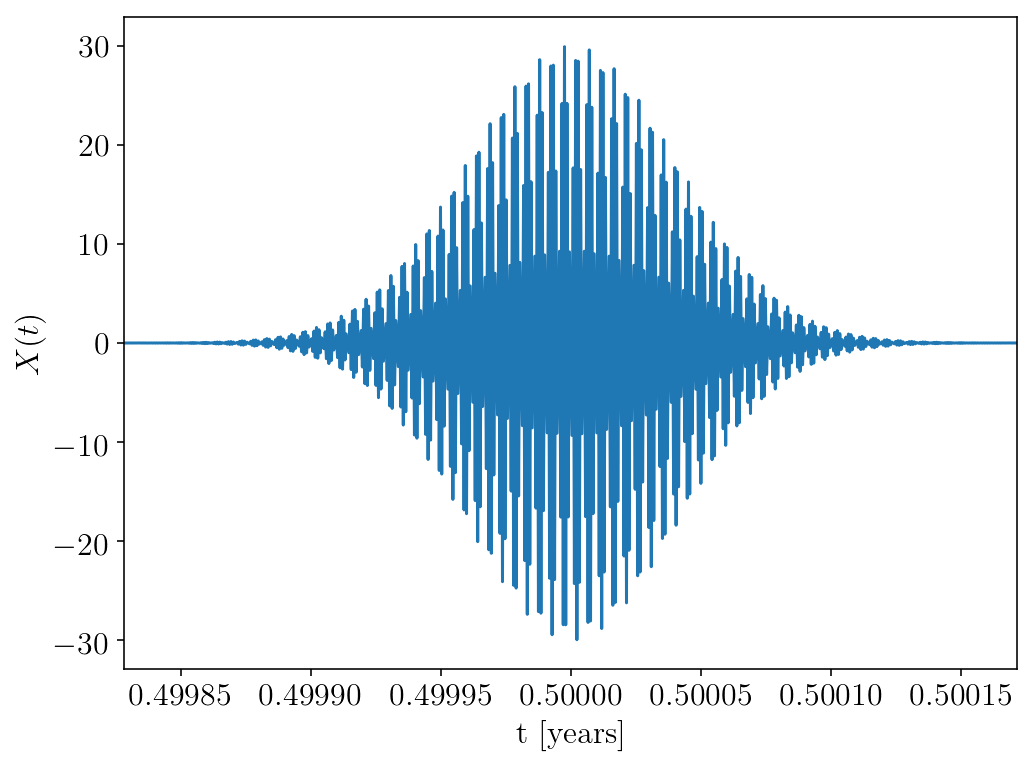

In [39]:
X_time_dom = np.fft.irfft(tdi.X)

fig, ax = plt.subplots(1, figsize=(8,6))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
ax.set_xlabel(r't [years]', fontsize=16)
ax.set_ylabel(r'$X(t)$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)

plt.xlim((wave.t0 - 3.*wave.tau)/l.YEAR, (wave.t0 + 3.*wave.tau)/l.YEAR)

ax.plot(t[1:-1]/l.YEAR, X_time_dom)

plt.show()

113.097335529


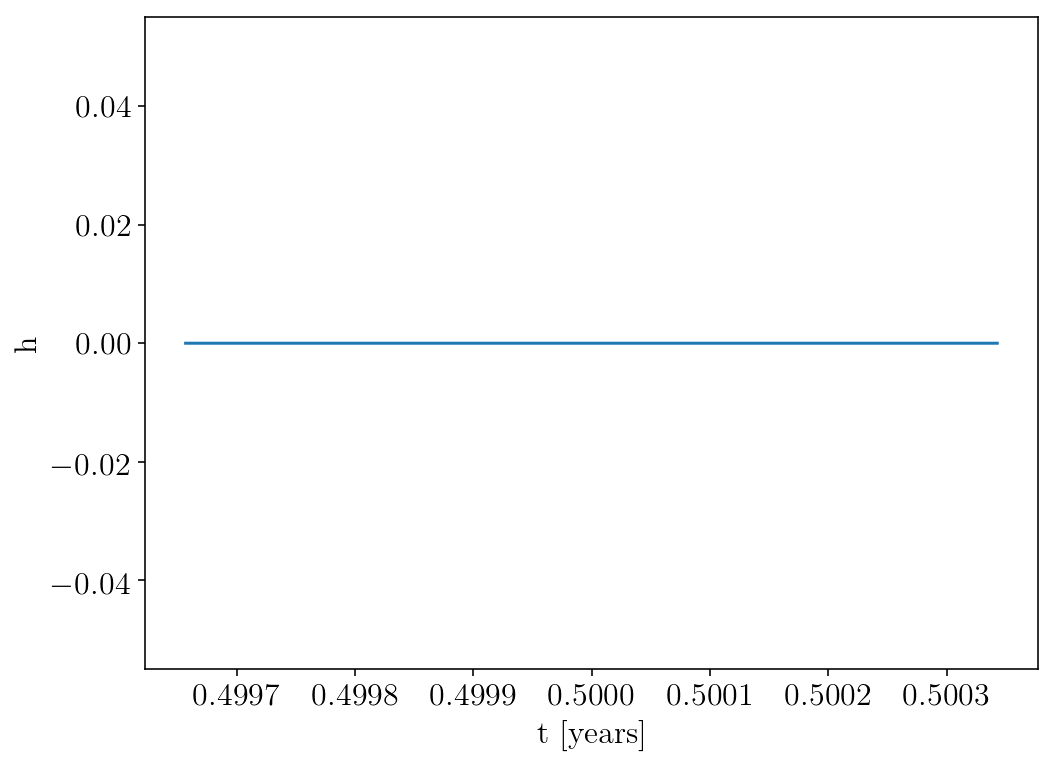

In [14]:
# set up parameters of wavelet
A    = 0.0
# f0   = 20.0e-3
# tau  = 0.07*3600.
# t0   = 0.5*l.YEAR
# phi0 = 0.0

print np.pi*f0*tau

wave2 = gl.Wavelet(A, f0, tau, t0, phi0)
wave2.set_t_h(orb)

# drop in the wavelet time series into the data stream
wave2.make_padded_h(t)

fig, ax = plt.subplots(1, figsize=(8,6))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
ax.set_xlabel(r't [years]', fontsize=16)
ax.set_ylabel(r'h', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)

ax.plot(wave2.t/l.YEAR, wave2.h)

plt.show()

In [7]:
phi = np.pi*0.2
theta = np.pi*0.25
psi = np.pi*0.23

gw = gl.GW_glitch(wave, wave2, theta, phi, psi, orb)

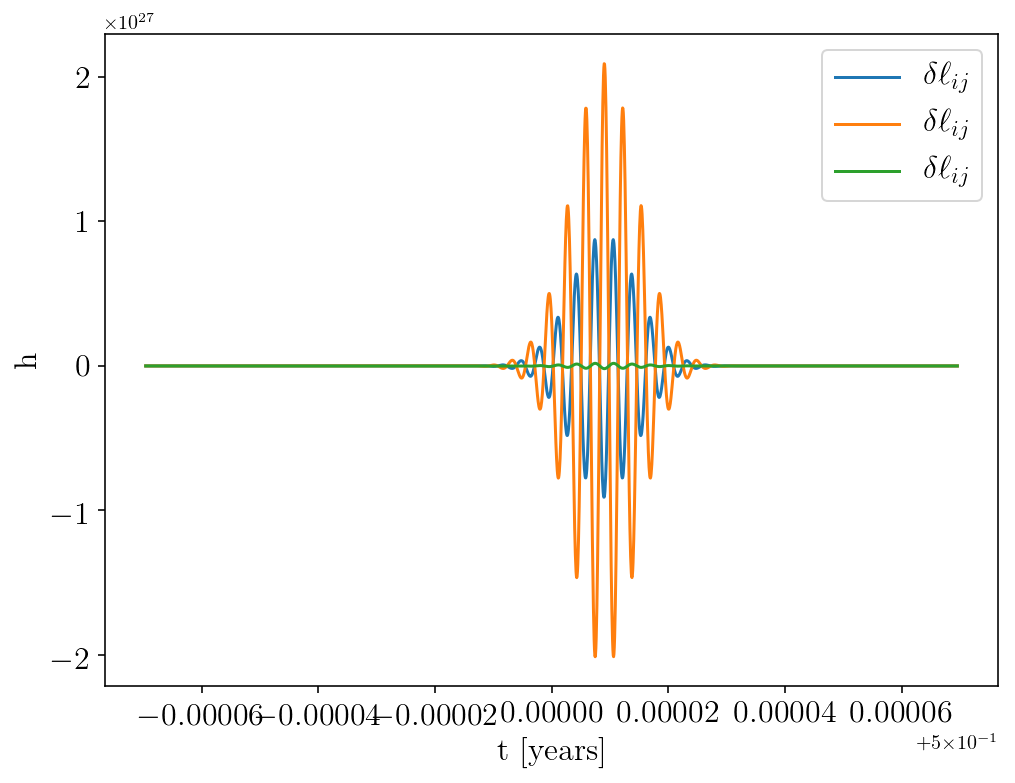

In [8]:
fig, ax = plt.subplots(1, figsize=(8,6))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
ax.set_xlabel(r't [years]', fontsize=16)
ax.set_ylabel(r'h', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)

ax.plot(gw.t/l.YEAR, gw.delta_l[0,2], label=r'$\delta\ell_{ij}$')
ax.plot(gw.t/l.YEAR, gw.delta_l[0,1], label=r'$\delta\ell_{ij}$')
ax.plot(gw.t/l.YEAR, gw.delta_l[1,2], label=r'$\delta\ell_{ij}$')

ax.legend(loc='upper right', fontsize=16)

plt.show()

In [9]:
gw.make_padded_delta_l(t)

p12 = gl.Phase(1,2, t, gw.delta_l_padded[0,1,:])
p21 = gl.Phase(2,1, t, gw.delta_l_padded[1,0,:])

p13 = gl.Phase(1,3, t, gw.delta_l_padded[0,2,:])
p31 = gl.Phase(3,1, t, gw.delta_l_padded[2,0,:])

p23 = gl.Phase(2,3, t, gw.delta_l_padded[1,2,:])
p32 = gl.Phase(3,2, t, gw.delta_l_padded[2,1,:])
   
p12.FT_phase(orb)
p21.FT_phase(orb)
p13.FT_phase(orb)
p31.FT_phase(orb)
p23.FT_phase(orb)
p32.FT_phase(orb)

tdi_GW = gl.TDI(p12, p21, p13, p31, p23, p32, orb)

In [10]:
noise = np.fft.irfft(tdi_GW.X)

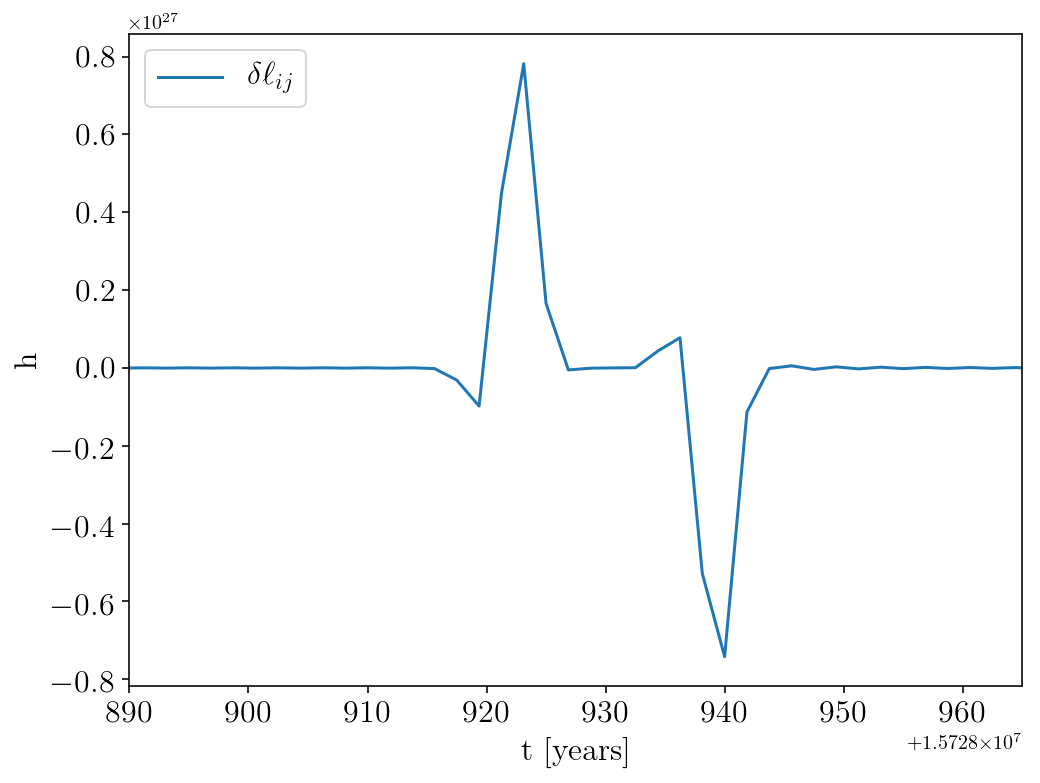

In [20]:
fig, ax = plt.subplots(1, figsize=(8,6))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
ax.set_xlabel(r't [years]', fontsize=16)
ax.set_ylabel(r'h', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)

#plt.xlim((wave.t0 + 100.*wave.tau)/l.YEAR, (wave.t0 + 130.*wave.tau)/l.YEAR)
plt.xlim((wave.t0 + 100.*wave.tau), (wave.t0 + 130.*wave.tau))



ax.plot(t[1:-1], noise.real, label=r'$\delta\ell_{ij}$')

ax.legend(loc='upper left', fontsize=16)



plt.show()

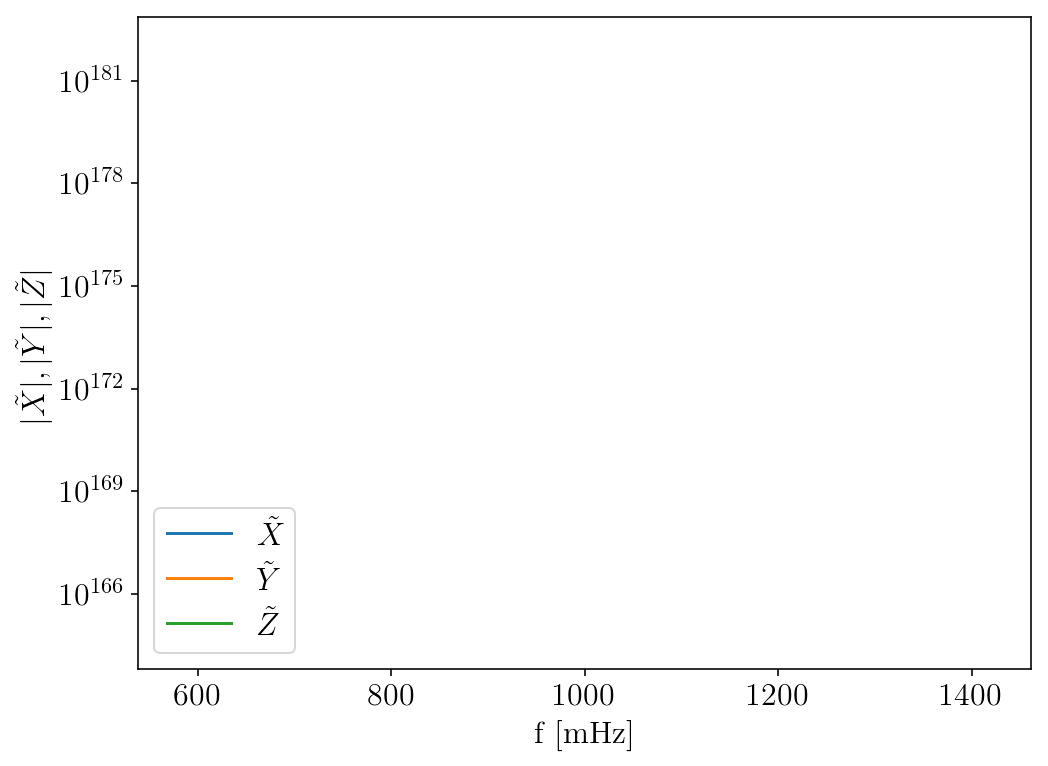

In [51]:
fig, ax = plt.subplots(1, figsize=(8,6))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

ax.set_xlabel(r'f [mHz]',fontsize=16)
ax.set_ylabel(r'$|\tilde{X}|,|\tilde{Y}|,|\tilde{Z}|$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)

mult = 1000.
plt.xlim(gw.hp_wavelet.f_min*mult, gw.hp_wavelet.f_max*mult)

ax.semilogy(tdi_GW.freqs*mult, np.abs(tdi_GW.X), label=r'$\tilde{X}$')
ax.semilogy(tdi_GW.freqs*mult, np.abs(tdi_GW.Y), label=r'$\tilde{Y}$')
ax.semilogy(tdi_GW.freqs*mult, np.abs(tdi_GW.Z), label=r'$\tilde{Z}$')

plt.legend(loc='lower left', fontsize=16)

plt.show()

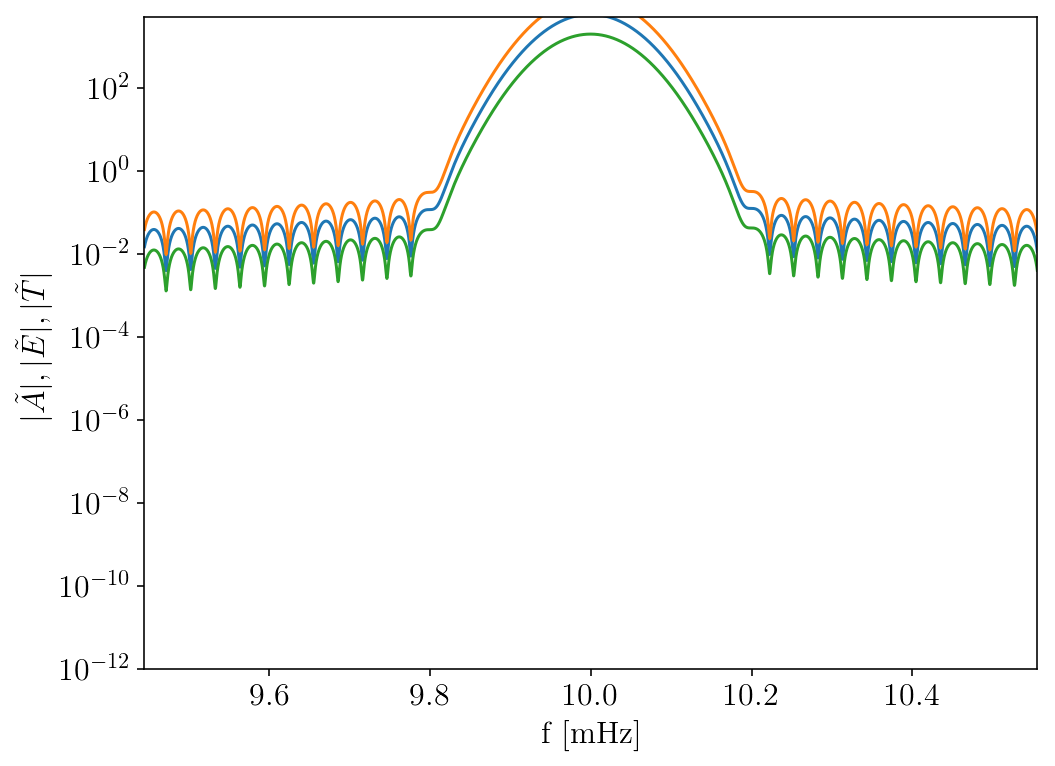

In [99]:
fig, ax = plt.subplots(1, figsize=(8,6))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

ax.set_xlabel(r'f [mHz]',fontsize=16)
ax.set_ylabel(r'$|\tilde{A}|,|\tilde{E}|,|\tilde{T}|$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)

mult = 1000.
plt.xlim(gw.hp_wavelet.f_min*mult, gw.hp_wavelet.f_max*mult)

ax.semilogy(tdi_GW.freqs*mult, np.abs(tdi_GW.A))
ax.semilogy(tdi_GW.freqs*mult, np.abs(tdi_GW.E))
ax.semilogy(tdi_GW.freqs*mult, np.abs(tdi_GW.T))

plt.ylim(1.0e-12, 5.0e3)

plt.show()

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,6))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

ax.set_ylabel(r'$|\tilde{X}|$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)

mult = 1000.
plt.xlim(wave.f_min*mult, wave.f_max*mult)

ax.semilogy(tdi.freqs*mult, np.abs(tdi.X), label=r'Instr.')
ax.semilogy(tdi_GW.freqs*mult, np.abs(tdi_GW.X), label=r'GW')

ax.legend(loc='lower left',fontsize=16)

plt.show()

In [107]:
mask = (tdi.freqs>1.0e-3) & (tdi.freqs<5.0e-3)
noise = orb.get_Sn(tdi.freqs[mask])

In [108]:
snr_GW_X = 4.0*np.sum( tdi_GW.X[mask]*np.conjugate(tdi_GW.X[mask])/noise).real/gw.N/orb.dt
print snr_GW_X

snr_GW_Y = 4.0*np.sum( tdi_GW.Y[mask]*np.conjugate(tdi_GW.Y[mask])/noise).real/gw.N/orb.dt
print snr_GW_Y

snr_GW_Z = 4.0*np.sum( tdi_GW.Z[mask]*np.conjugate(tdi_GW.Z[mask])/noise).real/gw.N/orb.dt
print snr_GW_Z

7.96363208324e+35
6.38028373371e+36
1.08091778007e+37


In [109]:
snr_GW = snr_GW_X + snr_GW_Y + snr_GW_Z
print np.sqrt(snr_GW)

4.240969788e+18


In [86]:
snr_X = 4.0*np.sum( tdi.X[mask]*np.conjugate(tdi.X[mask])/noise).real/gw.N/orb.dt
print snr_X

snr_Y = 4.0*np.sum( tdi.Y[mask]*np.conjugate(tdi.Y[mask])/noise).real/gw.N/orb.dt
print snr_Y

snr_Z = 4.0*np.sum( tdi.Z[mask]*np.conjugate(tdi.Z[mask])/noise).real/gw.N/orb.dt
print snr_Z

2.8185735754e+36
2.8185735754e+36
0.0


In [87]:
snr = snr_X + snr_Y + snr_Z
print np.sqrt(snr)

2.37426770832e+18


In [88]:
overlap_X = 4.0*np.sum( tdi.X[mask]*np.conjugate(tdi_GW.X[mask])/noise ).real/gw.N/orb.dt
print overlap_X/np.sqrt(snr*snr_GW)

overlap_Y = 4.0*np.sum( tdi.Y[mask]*np.conjugate(tdi_GW.Y[mask])/noise ).real/gw.N/orb.dt
print overlap_Y/np.sqrt(snr*snr_GW)

overlap_Z = 4.0*np.sum( tdi.Z[mask]*np.conjugate(tdi_GW.Z[mask])/noise ).real/gw.N/orb.dt
print overlap_Z/np.sqrt(snr*snr_GW)


-0.0822248744008
0.401990022096
0.0


In [89]:
overlap = overlap_X + overlap_Y + overlap_Z

print overlap/np.sqrt(snr*snr_GW)

0.319765147696
